# Look at SiPM PSF for N100

This notebook shows how to extract the PSFs from Kr events and their reading.

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io  .dst_io         as     dstio

from IC.invisible_cities.database              import load_db
#from IC.invisible_cities.io      .kdst_io      import psf_writer
# he's dead jim, make psf_writer yourself

## code deprecated, including here

In [2]:
class PSFfactors(tb.IsDescription):
    nevt   = tb. UInt32Col(pos=0)
    xr     = tb.Float32Col(pos=1)
    yr     = tb.Float32Col(pos=2)
    zr     = tb.Float32Col(pos=3)
    x      = tb.Float32Col(pos=4)
    y      = tb.Float32Col(pos=5)
    z      = tb.Float32Col(pos=6)
    factor = tb.Float32Col(pos=7)

def psf_writer(hdf5_file, **kwargs):
    psf_table = make_table(hdf5_file,
                           group       = "PSF",
                           name        = "PSFs",
                           fformat     = PSFfactors,
                           description = "XYZ dependent point spread functions",
                           compression = 'ZLIB4')

    def write_psf(xr, yr, zr, xp, yp, zp, fr, nr):
        row = psf_table.row
        for i, x in enumerate(xr):
            for j, y in enumerate(yr):
                for k, z in enumerate(zr):
                    row["xr"    ] = x
                    row["yr"    ] = y
                    row["zr"    ] = z
                    row["x"     ] = xp
                    row["y"     ] = yp
                    row["z"     ] = zp
                    row["factor"] = fr[i,j,k]
                    row["nevt"  ] = nr[i,j,k]
                    row.append()
    return write_psf

## Read the PSF

In [3]:
psf_path  = 'psfs/'
psf_path2 = '../Tl_studies/psf_study/psfs/'

Load in 3 atm:
- Gonzalo's (cross check)
- Mine
- Martíns 5 bar MC

In [63]:
#psf =  dstio.load_dst(psf_path + 'demopp.kr83m_MC_RUN8.psf.h5', 'PSF', 'PSFs')

psf_data_MC = dstio.load_dst(psf_path + 'NEXT100_PSF_kr83m_5bar.h5', 'PSF', 'PSFs')
psf_data_mine = dstio.load_dst(psf_path + 'eutropia_14675_PSF_merged_sectors.h5', 'PSF', 'PSFs')
psf_data_gonzalo = dstio.load_dst(psf_path + 'psf_14675_5mm.h5', 'PSF', 'PSFs')
psf_MC_4bar = dstio.load_dst(psf_path + 'n100_mc_4bar.psf', 'PSF', 'PSFs')

In [14]:
#psf =  dstio.load_dst(psf_path + 'demopp.kr83m_MC_RUN8.psf.h5', 'PSF', 'PSFs')


psf_data10 = dstio.load_dst(psf_path2 + 'demopp.kr83m_DATA_RUN10.psf.h5', 'PSF', 'PSFs')
psf_dataN100 = dstio.load_dst(psf_path2 + 'NEXT100_PSF_kr83m_5bar.h5', 'PSF', 'PSFs')
psf_NEW = dstio.load_dst(psf_path2 + 'V3_PSF_dst_bin1.0_sum_collapsed_rAll.h5', 'PSF', 'PSFs')



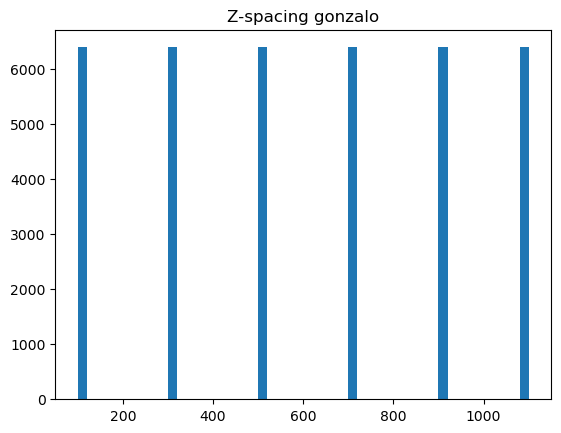

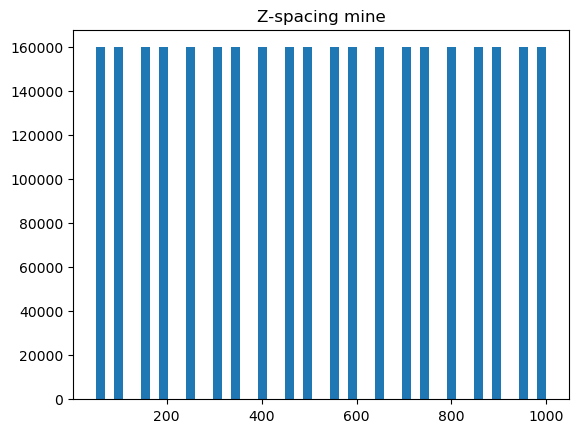

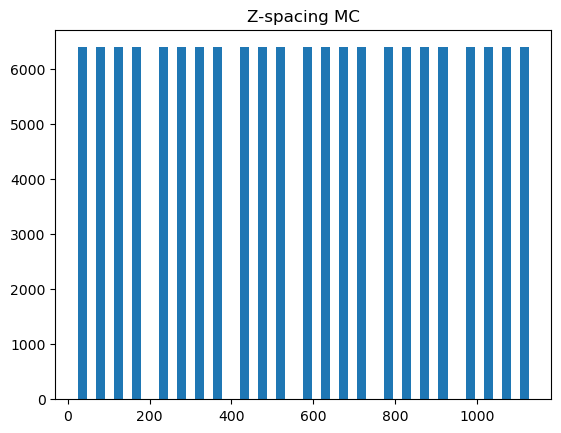

In [6]:
plt.hist(psf_data_gonzalo.z, bins=50)
plt.title("Z-spacing gonzalo")
plt.show()
plt.hist(psf_data_mine.z, bins=50)
plt.title("Z-spacing mine")
plt.show()
plt.hist(psf_data_MC.z, bins=50)
plt.title("Z-spacing MC")
plt.show()

#### I then skip all of this until I get to the multi-PSF plotter

In [7]:
psf[(psf.z == z_pos) & (psf.xr == 0) & (psf.yr == 0)]

NameError: name 'psf' is not defined

In [ ]:
display(psf_data8)
print(psf_data8.x.unique())

,nevt,xr,yr,zr,x,y,z,factor
0,176,-49.0,-49.0,0.0,0.0,0.0,10.0,0.000000
1,588,-49.0,-49.0,0.0,0.0,0.0,30.0,0.000040
2,820,-49.0,-49.0,0.0,0.0,0.0,50.0,0.000094
3,940,-49.0,-49.0,0.0,0.0,0.0,70.0,0.000378
4,964,-49.0,-49.0,0.0,0.0,0.0,90.0,0.000240
...,...,...,...,...,...,...,...,...
166612,1400,49.0,49.0,0.0,0.0,0.0,250.0,0.000355
166613,1588,49.0,49.0,0.0,0.0,0.0,270.0,0.000090
166614,1260,49.0,49.0,0.0,0.0,0.0,290.0,0.000136
166615,1356,49.0,49.0,0.0,0.0,0.0,310.0,0.000150


[0.]


In [8]:
z_pos = 70.
z_pos_N100_low = 25.
z_pos_N100_high = 75.
y_pos = 0.

### we dont have the MC, so ignore the MC output

In [24]:
print(psf_weird_one.z.unique())

[  10.   30.   50.   70.   90.  110.  130.  150.  170.  190.  210.  230.
  250.  270.  290.  310.  330.  350.  370.  390.  410.  430.  450.  470.
  490.  510.  530.  550.  570.  590.  610.  630.  650.  670.  690.  710.
  730.  750.  770.  790.  810.  830.  850.  870.  890.  910.  930.  950.
  970.  990. 1010. 1030. 1050. 1070. 1090. 1110. 1130. 1150. 1170. 1190.
 1210.]


,xr,yr,zr,x,y,z,factor,nevt
0,-497.5,-497.5,0,-250.0,-250.0,50.0,0.0,0.0
1,-497.5,-497.5,0,-250.0,-250.0,100.0,0.0,0.0
2,-497.5,-497.5,0,-250.0,-250.0,150.0,0.0,0.0
3,-497.5,-497.5,0,-250.0,-250.0,200.0,0.0,0.0
4,-497.5,-497.5,0,-250.0,-250.0,250.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3199995,497.5,497.5,0,250.0,250.0,800.0,0.0,0.0
3199996,497.5,497.5,0,250.0,250.0,850.0,0.0,0.0
3199997,497.5,497.5,0,250.0,250.0,900.0,0.0,0.0
3199998,497.5,497.5,0,250.0,250.0,950.0,0.0,0.0


,xr,yr,zr,x,y,z,factor,nevt
0,-197.5,-197.5,0.0,0.0,0.0,100.0,0.000025,7813
1,-197.5,-197.5,0.0,0.0,0.0,300.0,0.000047,9063
2,-197.5,-197.5,0.0,0.0,0.0,500.0,0.000066,7345
3,-197.5,-197.5,0.0,0.0,0.0,700.0,0.000104,5564
4,-197.5,-197.5,0.0,0.0,0.0,900.0,0.000059,3271
...,...,...,...,...,...,...,...,...
38395,197.5,197.5,0.0,0.0,0.0,300.0,0.000045,9514
38396,197.5,197.5,0.0,0.0,0.0,500.0,0.000073,7961
38397,197.5,197.5,0.0,0.0,0.0,700.0,0.000090,5778
38398,197.5,197.5,0.0,0.0,0.0,900.0,0.000093,3393


,xr,yr,zr,x,y,z,factor,nevt
0,-39.5,-39.5,0,0.0,0.0,25.0,0.000793,109.0
1,-39.5,-39.5,0,0.0,0.0,75.0,0.000713,137.0
2,-39.5,-39.5,0,0.0,0.0,125.0,0.000715,132.0
3,-39.5,-39.5,0,0.0,0.0,175.0,0.000758,121.0
4,-39.5,-39.5,0,0.0,0.0,225.0,0.000701,108.0
...,...,...,...,...,...,...,...,...
147195,39.5,39.5,0,0.0,0.0,925.0,0.000705,116.0
147196,39.5,39.5,0,0.0,0.0,975.0,0.000844,131.0
147197,39.5,39.5,0,0.0,0.0,1025.0,0.000745,128.0
147198,39.5,39.5,0,0.0,0.0,1075.0,0.001015,142.0


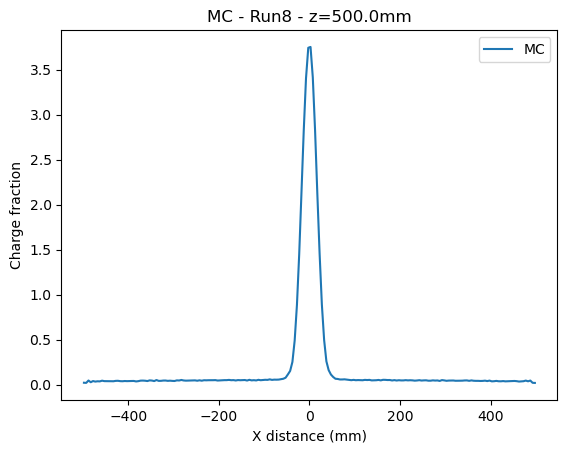

In [60]:
# testing a differing psf
display(psf_data_mine)
display(psf_data_gonzalo)
display(psf_data_MC)

bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)


z_pos = 500.0
psf_cut = psf_data_mine[(psf_data_mine.z == z_pos)]
x, y = sorted(set(psf_cut.xr)), psf_cut.groupby(['xr'])['factor'].sum().values

plt.plot(x, y, label = 'MC')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'MC - Run8 - z={z_pos}mm')
plt.legend()


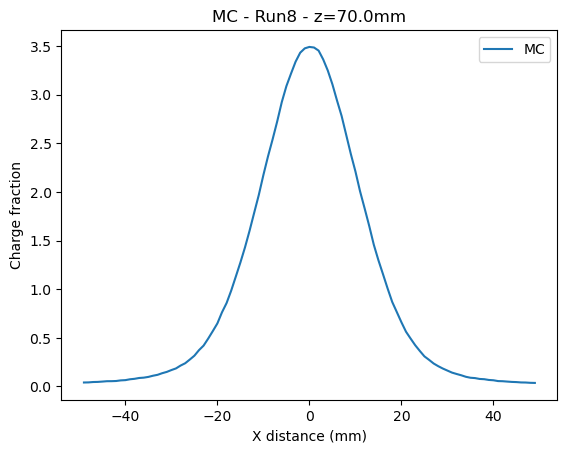

In [22]:
bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

psf_cut = psf[(psf.z == z_pos)]
x, y = sorted(set(psf_cut.xr)), psf_cut.groupby(['xr'])['factor'].sum().values


plt.plot(x, y, label = 'MC')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'MC - Run8 - z={z_pos}mm')
plt.legend()

## Here lets do all the ones we have

In [7]:
def norma(data):
    return (data)/(max(data))

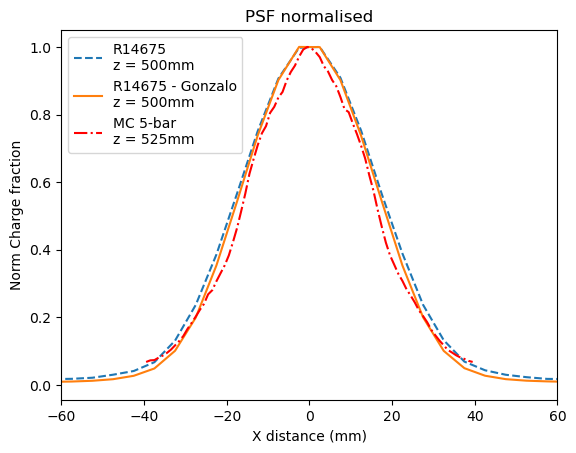

In [8]:
z_pos_mine = 500
psf_data_mine_cut = psf_data_mine[(psf_data_mine.z == z_pos_mine)]
x_data8, y_data8 = sorted(set(psf_data_mine_cut.xr)), psf_data_mine_cut.groupby(['xr'])['factor'].sum().values


z_pos_gonzalo = 500
psf_data_gonza_cut = psf_data_gonzalo[(psf_data_gonzalo.z == z_pos_gonzalo)]
x_data_gonz, y_data_gonz = sorted(set(psf_data_gonza_cut.xr)), psf_data_gonza_cut.groupby(['xr'])['factor'].sum().values


z_pos_MC = 525
psf_data_MC_cut = psf_data_MC[(psf_data_MC.z == z_pos_MC)]
x_dataMC, y_dataMC = sorted(set(psf_data_MC_cut.xr)), psf_data_MC_cut.groupby(['xr'])['factor'].sum().values


#plt.plot(x_data8, y_data8, label = 'data8')
#plt.plot(x_data9, y_data9, label = 'data9')
plt.plot(x_data8, norma(y_data8), label = f'R14675\nz = {z_pos_mine}mm', linestyle = '--')
plt.plot(x_data_gonz, norma(y_data_gonz), label = f'R14675 - Gonzalo\nz = {z_pos_gonzalo}mm')
plt.plot(x_dataMC, norma(y_dataMC), label = f'MC 5-bar\nz = {z_pos_MC}mm', color = 'red', linestyle = '-.')

plt.ylabel("Norm Charge fraction")
plt.xlabel("X distance (mm)")
plt.title("PSF normalised")
plt.xlim([-60, 60])
plt.legend(loc='upper left')
plt.show()

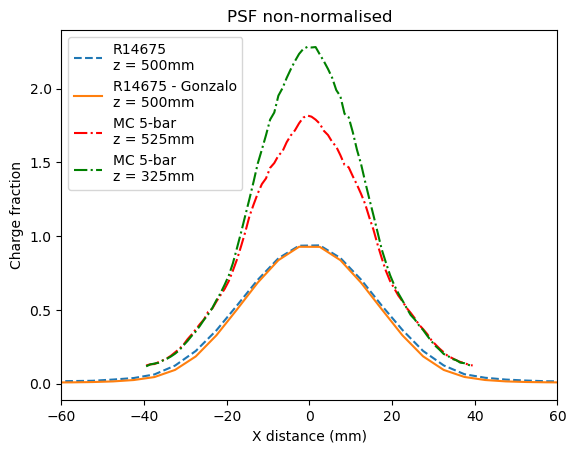

In [25]:
plt.plot(x_data8, (y_data8), label = f'R14675\nz = {z_pos_mine}mm', linestyle = '--')
plt.plot(x_data_gonz, (y_data_gonz), label = f'R14675 - Gonzalo\nz = {z_pos_gonzalo}mm')
plt.plot(x_dataMC, (y_dataMC), label = f'MC 5-bar\nz = {z_pos_MC}mm', color = 'red', linestyle = '-.')

z_pos_MC = 325
psf_data_MC_cut = psf_data_MC[(psf_data_MC.z == z_pos_MC)]
x_dataMC, y_dataMC = sorted(set(psf_data_MC_cut.xr)), psf_data_MC_cut.groupby(['xr'])['factor'].sum().values

plt.plot(x_dataMC, (y_dataMC), label = f'MC 5-bar\nz = {z_pos_MC}mm', color = 'green', linestyle = '-.')

plt.ylabel("Charge fraction")
plt.xlabel("X distance (mm)")
plt.title("PSF non-normalised")
plt.xlim([-60, 60])
plt.legend(loc='upper left')
plt.show()

### okay lets create some bands

In [10]:
def create_psf_line(data, z_val, y_val = 0):
    cut_data = data[(data.z == z_val)]
    psf_data_mine_cut = cut_data[cut_data.yr == y_val]
    x_data8, y_data8 = sorted(set(psf_data_mine_cut.xr)), psf_data_mine_cut.groupby(['xr'])['factor'].sum().values

    return (x_data8, y_data8)

def create_bands(data, lower, upper, y_val = 0):
    data_l = data[(data.z == lower)]
    data_l = data_l[data_l.yr == y_val]
    x_data_l, y_data_l = sorted(set(data_l.xr)), data_l.groupby(['xr'])['factor'].sum().values

    data_h = data[(data.z == upper)]
    data_h = data_h[data_h.yr == y_val]
    x_data_h, y_data_h = sorted(set(data_h.xr)), data_h.groupby(['xr'])['factor'].sum().values


    return (x_data_l, y_data_l, x_data_h, y_data_h)


def create_fill_plot(bands, label = 'plot', c = 'green', norm = False, ls = 'solid'):
    '''
    This plot takes the output from create_bands() and applies the plotting
    '''
    if not norm:
        ### DATA
        plt.plot(bands[0], (bands[1]), label = label, color = c, linestyle = ls)
        plt.plot(bands[2], (bands[3]), color = c, linestyle = ls)
        # fill
        plt.fill_between(bands[0], (bands[1]), (bands[3]), facecolor=c, alpha = 0.5)
    else:
        ### DATA
        plt.plot(bands[0], norma(bands[1]), label = label, color = c)
        plt.plot(bands[2], norma(bands[3]), color = c)
        # fill
        plt.fill_between(bands[0], norma(bands[1]), norma(bands[3]), facecolor=c, alpha = 0.5)

In [26]:
z_upper = 900
z_lower = 200

z_MC_lower = 225
z_MC_upper = 925

r14675_bands = create_bands(psf_data_mine, z_lower, z_upper)
mc_bands = create_bands(psf_data_MC, z_MC_lower, z_MC_upper)




### DATA
plt.plot(r14675_bands[0], norma(r14675_bands[1]), label = f'R14675\nz={z_lower}-{z_upper} mm', color = 'green')
plt.plot(r14675_bands[2], norma(r14675_bands[3]), color = 'green')
# fill
plt.fill_between(r14675_bands[0], norma(r14675_bands[1]), norma(r14675_bands[3]), facecolor='green', alpha = 0.5)

### MC
plt.plot(mc_bands[0], norma(mc_bands[1]), label = f'MC 5-bar\nz={z_MC_lower}-{z_MC_upper} mm', color = 'red')
plt.plot(mc_bands[2], norma(mc_bands[3]), color = 'red')
# fill
plt.fill_between(mc_bands[0], norma(mc_bands[1]), norma(mc_bands[3]), facecolor='red', alpha = 0.5)





#plt.plot(x_data8, y_data8, label = 'data8')
#plt.plot(x_data9, y_data9, label = 'data9')
#plt.plot(x_data8, norm(y_data8), label = f'R14675\nz = {z_pos_mine}mm')
#plt.plot(x_data_gonz, norm(y_data_gonz), label = f'R14675 - Gonzalo\nz = {z_pos_gonzalo}mm')
#plt.plot(x_dataMC, norm(y_dataMC), label = f'MC 5-bar\nz = {z_pos_MC}mm', color = 'red')

plt.ylabel("Charge fraction")
plt.xlabel("X distance (mm)")
plt.title("PSF normalised")
plt.xlim([-60, 60])
plt.legend(loc='upper left')
plt.show()

ValueError: max() arg is an empty sequence

### BANDS WITH NEW AND DEMO

In [16]:
print("psf_data10")
display(psf_data10)
print("psf_NEW")
display(psf_NEW)
print("psf_data_MC")
display(psf_data_MC)
print("psf_data_mine")
display(psf_data_mine)
print("psf_gonzalo")
display(psf_data_gonzalo)
print(psf_data_gonzalo.yr.unique())

psf_data10


,nevt,xr,yr,zr,x,y,z,factor
0,195,-49.0,-49.0,0.0,0.0,0.0,10.0,0.000562
1,181,-49.0,-48.0,0.0,0.0,0.0,10.0,0.000542
2,192,-49.0,-47.0,0.0,0.0,0.0,10.0,0.000505
3,192,-49.0,-46.0,0.0,0.0,0.0,10.0,0.000432
4,237,-49.0,-45.0,0.0,0.0,0.0,10.0,0.000431
...,...,...,...,...,...,...,...,...
156811,1011,49.0,45.0,0.0,0.0,0.0,310.0,0.000370
156812,1063,49.0,46.0,0.0,0.0,0.0,310.0,0.000293
156813,1059,49.0,47.0,0.0,0.0,0.0,310.0,0.000246
156814,1004,49.0,48.0,0.0,0.0,0.0,310.0,0.000362


psf_NEW


,xr,yr,zr,x,y,z,factor,nevt
0,-49.5,-49.5,0.0,0.0,0.0,12.5,0.000036,4839
1,-49.5,-49.5,0.0,0.0,0.0,37.5,0.000010,8436
2,-49.5,-49.5,0.0,0.0,0.0,62.5,0.000015,8133
3,-49.5,-49.5,0.0,0.0,0.0,87.5,0.000031,7816
4,-49.5,-49.5,0.0,0.0,0.0,112.5,0.000021,7726
...,...,...,...,...,...,...,...,...
219995,49.5,49.5,0.0,0.0,0.0,437.5,0.000049,7349
219996,49.5,49.5,0.0,0.0,0.0,462.5,0.000011,7501
219997,49.5,49.5,0.0,0.0,0.0,487.5,0.000009,7361
219998,49.5,49.5,0.0,0.0,0.0,512.5,0.000174,7366


psf_data_MC


,xr,yr,zr,x,y,z,factor,nevt
0,-39.5,-39.5,0,0.0,0.0,25.0,0.000793,109.0
1,-39.5,-39.5,0,0.0,0.0,75.0,0.000713,137.0
2,-39.5,-39.5,0,0.0,0.0,125.0,0.000715,132.0
3,-39.5,-39.5,0,0.0,0.0,175.0,0.000758,121.0
4,-39.5,-39.5,0,0.0,0.0,225.0,0.000701,108.0
...,...,...,...,...,...,...,...,...
147195,39.5,39.5,0,0.0,0.0,925.0,0.000705,116.0
147196,39.5,39.5,0,0.0,0.0,975.0,0.000844,131.0
147197,39.5,39.5,0,0.0,0.0,1025.0,0.000745,128.0
147198,39.5,39.5,0,0.0,0.0,1075.0,0.001015,142.0


psf_data_mine


,xr,yr,zr,x,y,z,factor,nevt
0,-497.5,-497.5,0,0.0,0.0,50.0,0.000000,24.0
1,-497.5,-497.5,0,0.0,0.0,100.0,0.000099,29.0
2,-497.5,-497.5,0,0.0,0.0,150.0,0.000000,27.0
3,-497.5,-497.5,0,0.0,0.0,200.0,0.000000,34.0
4,-497.5,-497.5,0,0.0,0.0,250.0,0.000000,25.0
...,...,...,...,...,...,...,...,...
799995,497.5,497.5,0,0.0,0.0,800.0,0.000000,33.0
799996,497.5,497.5,0,0.0,0.0,850.0,0.000000,34.0
799997,497.5,497.5,0,0.0,0.0,900.0,0.000000,40.0
799998,497.5,497.5,0,0.0,0.0,950.0,0.000000,47.0


psf_gonzalo


,xr,yr,zr,x,y,z,factor,nevt
0,-197.5,-197.5,0.0,0.0,0.0,100.0,0.000025,7813
1,-197.5,-197.5,0.0,0.0,0.0,300.0,0.000047,9063
2,-197.5,-197.5,0.0,0.0,0.0,500.0,0.000066,7345
3,-197.5,-197.5,0.0,0.0,0.0,700.0,0.000104,5564
4,-197.5,-197.5,0.0,0.0,0.0,900.0,0.000059,3271
...,...,...,...,...,...,...,...,...
38395,197.5,197.5,0.0,0.0,0.0,300.0,0.000045,9514
38396,197.5,197.5,0.0,0.0,0.0,500.0,0.000073,7961
38397,197.5,197.5,0.0,0.0,0.0,700.0,0.000090,5778
38398,197.5,197.5,0.0,0.0,0.0,900.0,0.000093,3393


[-197.5 -192.5 -187.5 -182.5 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5
 -147.5 -142.5 -137.5 -132.5 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5
  -97.5  -92.5  -87.5  -82.5  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5
  -47.5  -42.5  -37.5  -32.5  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5
    2.5    7.5   12.5   17.5   22.5   27.5   32.5   37.5   42.5   47.5
   52.5   57.5   62.5   67.5   72.5   77.5   82.5   87.5   92.5   97.5
  102.5  107.5  112.5  117.5  122.5  127.5  132.5  137.5  142.5  147.5
  152.5  157.5  162.5  167.5  172.5  177.5  182.5  187.5  192.5  197.5]


Text(0.5, 0, 'X distance (mm)')

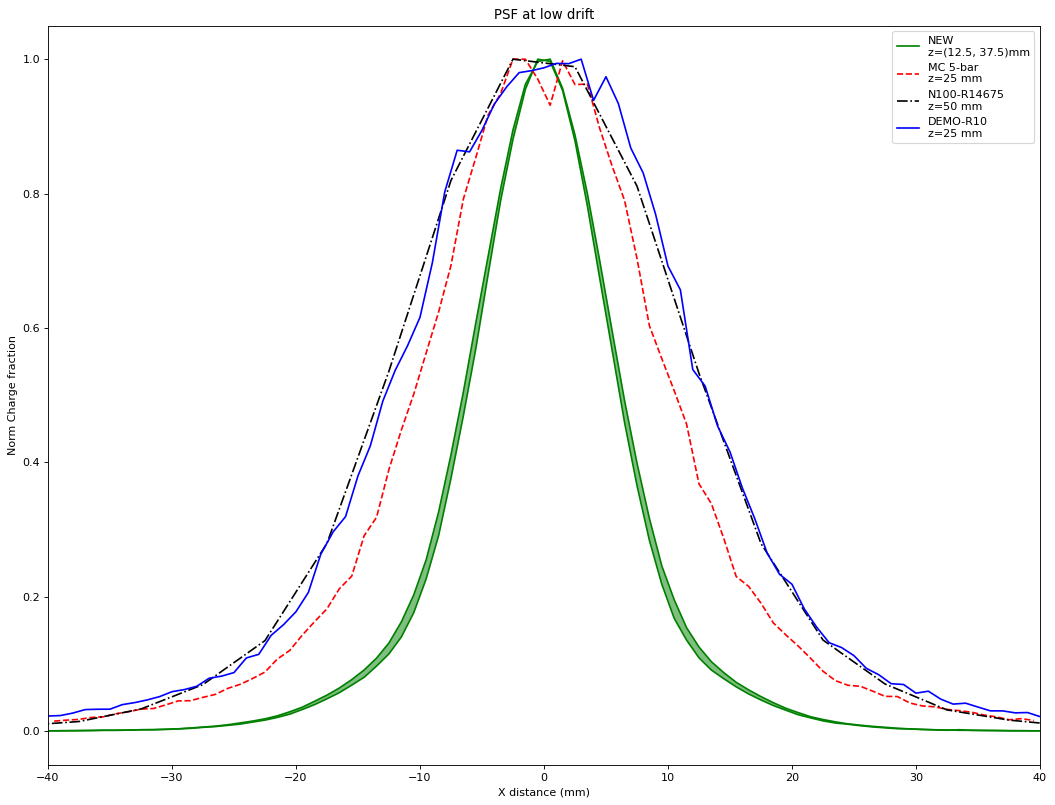

In [28]:
norm = True

demo_lower = 50 # mm
demo_upper = 70 # mm

new_lower  = 12.5 # mm
new_upper  = 37.5 # mm

mc_standard = 25 # mm
n100_data   = 50 # mm

plt.figure(figsize=(16, 12), dpi=80)


# new and demo
demo_bands = create_bands(psf_data10, demo_lower, demo_upper, y_val = 1)
new_bands  = create_bands(psf_NEW, new_lower, new_upper, y_val = 0.5)

#create_fill_plot(demo_bands, label = f'DEMO-R10\nz={demo_lower, demo_upper}mm', c = 'blue', norm = norm)
create_fill_plot(new_bands, label = f'NEW\nz={new_lower, new_upper}mm', norm = norm)

# n100
n100_MC = create_psf_line(psf_data_MC, z_val = mc_standard, y_val = 0.5)
n100_res = create_psf_line(psf_data_mine, z_val = n100_data, y_val = 2.5)
n100_demo = create_psf_line(psf_data10, z_val = demo_lower, y_val = 1)

if norm:
    plt.plot(n100_MC[0], norma(n100_MC[1]), label = f'MC 5-bar\nz={mc_standard} mm', color = 'red', linestyle = 'dashed')
    plt.plot(n100_res[0], norma(n100_res[1]), label = f'N100-R14675\nz={n100_data} mm', color = 'black', linestyle = 'dashdot')
    plt.plot(n100_demo[0], norma(n100_demo[1]), label = f'DEMO-R10\nz={mc_standard} mm', color = 'blue')
    plt.ylabel("Norm Charge fraction")
else:
    plt.plot(n100_MC[0], (n100_MC[1]), label = f'MC 5-bar\nz={mc_standard} mm', color = 'red')
    plt.plot(n100_res[0], (n100_res[1]), label = f'N100-R14675\nz={n100_data} mm', color = 'black')
    plt.plot(n100_demo[0], (n100_demo[1]), label = f'DEMO-R10\nz={mc_standard} mm', color = 'blue')
    plt.ylabel("Charge fraction")


plt.legend()
plt.xlim([-40, 40])
plt.title("PSF at low drift")
plt.xlabel("X distance (mm)")


### lets remove the bands

Text(0.5, 0, 'X distance (mm)')

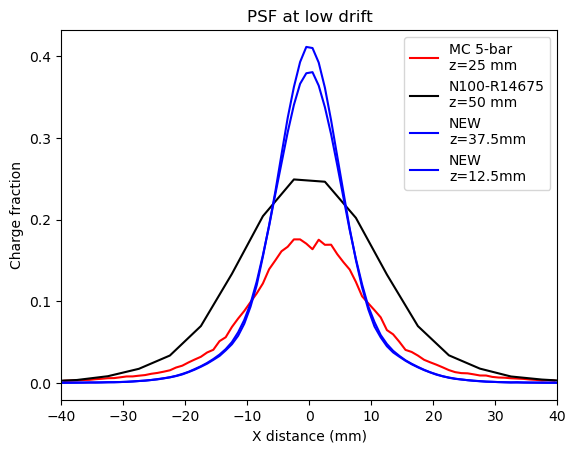

In [20]:
norm = False

demo_lower = 50 # mm
demo_upper = 70 # mm

new_lower  = 12.5 # mm
new_upper  = 37.5 # mm

mc_standard = 25 # mm
n100_data   = 50 # mm

# new and demo
#demo_bands = create_bands(psf_data10, demo_lower, demo_upper, y_val = 1)
#new_bands  = create_bands(psf_NEW, new_lower, new_upper, y_val = 0.5)

#create_fill_plot(demo_bands, label = f'DEMO-R10\nz={demo_lower, demo_upper}mm', c = 'blue', norm = norm)
#create_fill_plot(new_bands, label = f'NEW\nz={new_lower, new_upper}mm', norm = norm)

# n100
n100_MC = create_psf_line(psf_data_MC, z_val = mc_standard, y_val = 0.5)
n100_res = create_psf_line(psf_data_mine, z_val = n100_data, y_val = 2.5)

new_u = create_psf_line(psf_NEW, z_val = new_upper, y_val = 0.5)
new_l = create_psf_line(psf_NEW, z_val = new_lower, y_val = 0.5)


if norm:
    plt.plot(n100_MC[0], norma(n100_MC[1]), label = f'MC 5-bar\nz={mc_standard} mm', color = 'red')
    plt.plot(n100_res[0], norma(n100_res[1]), label = f'N100-R14675\nz={n100_data} mm', color = 'black')
    plt.ylabel("Norm Charge fraction")
else:
    plt.plot(n100_MC[0], (n100_MC[1]), label = f'MC 5-bar\nz={mc_standard} mm', color = 'red')
    plt.plot(n100_res[0], (n100_res[1]), label = f'N100-R14675\nz={n100_data} mm', color = 'black')

    plt.plot(new_u[0], (new_u[1]), label = f'NEW\nz={new_upper}mm', color = 'blue')
    plt.plot(new_l[0], (new_l[1]), label = f'NEW\nz={new_lower}mm', color = 'blue')
    plt.ylabel("Charge fraction")


plt.legend()
plt.xlim([-40, 40])
plt.title("PSF at low drift")
plt.xlabel("X distance (mm)")


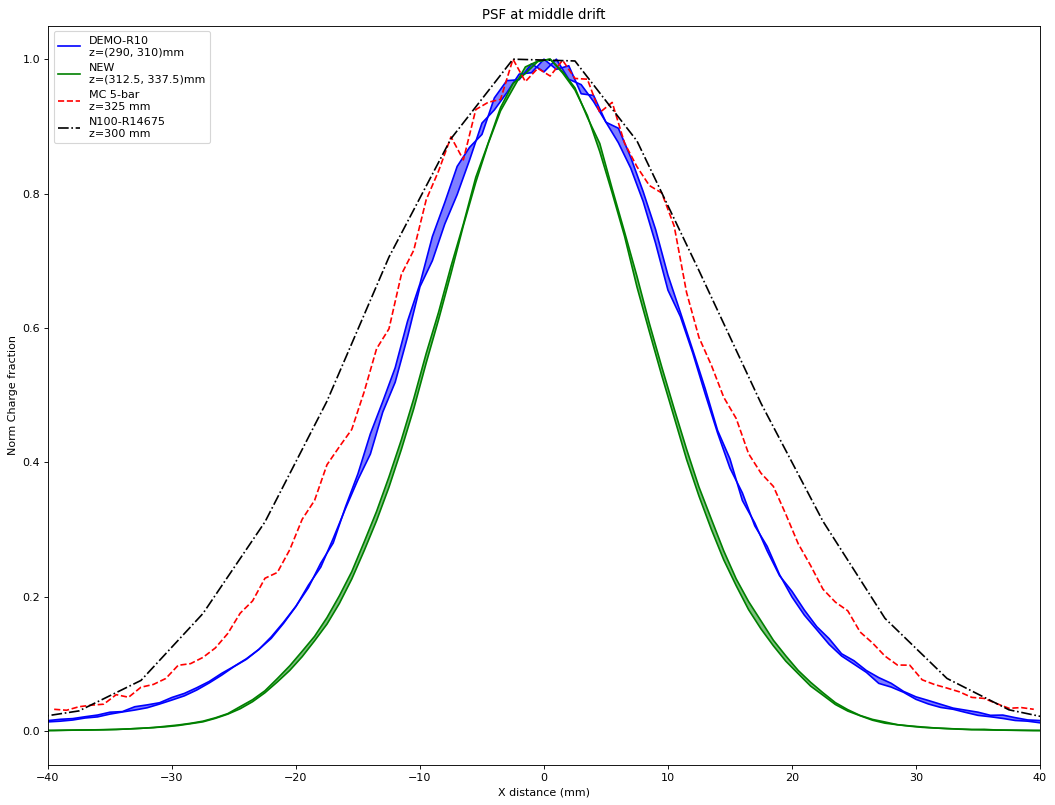

In [30]:
norm = True

demo_lower = 290 # mm
demo_upper = 310 # mm

new_lower  = 312.5 # mm
new_upper  = 337.5 # mm

mc_standard = 325 # mm
n100_data   = 300 # mm

plt.figure(figsize=(16, 12), dpi=80)

# new and demo
demo_bands = create_bands(psf_data10, demo_lower, demo_upper, y_val = 0)
new_bands  = create_bands(psf_NEW, new_lower, new_upper, y_val = 0.5)

create_fill_plot(demo_bands, label = f'DEMO-R10\nz={demo_lower, demo_upper}mm', c = 'blue', norm = norm)
create_fill_plot(new_bands, label = f'NEW\nz={new_lower, new_upper}mm', norm = norm)

# n100
n100_MC = create_psf_line(psf_data_MC, z_val = mc_standard, y_val = 0.5)

# n100
n100_MC_gonz = create_psf_line(psf_data_gonzalo, z_val = n100_data, y_val = 2.5)

n100_res = create_psf_line(psf_data_mine, z_val = n100_data, y_val = 2.5)



if norm:
    plt.plot(n100_MC[0], norma(n100_MC[1]), label = f'MC 5-bar\nz={mc_standard} mm', color = 'red', linestyle = 'dashed')
    plt.plot(n100_res[0], norma(n100_res[1]), label = f'N100-R14675\nz={n100_data} mm', color = 'black', linestyle = 'dashdot')
    #plt.plot(n100_MC_gonz[0], norma(n100_MC_gonz[1]), label = f'N100-R14675 GONZALO\nz={n100_data} mm', color = 'purple')

else:
    plt.plot(n100_MC[0], (n100_MC[1]), label = f'MC 5-bar\nz={mc_standard} mm', color = 'red', linestyle = 'dashed')
    plt.plot(n100_res[0], (n100_res[1]), label = f'N100-R14675\nz={n100_data} mm', color = 'black', linestyle = 'dashdot')
    #plt.plot(n100_MC_gonz[0], (n100_MC_gonz[1]), label = f'N100-R14675 GONZALO\nz={n100_data} mm', color = 'purple')


plt.legend(loc = 'upper left')
plt.xlim([-40, 40])
plt.title("PSF at middle drift")
plt.xlabel("X distance (mm)")

if norm :
    plt.ylabel("Norm Charge fraction")
else:
    plt.ylabel("Charge fraction")

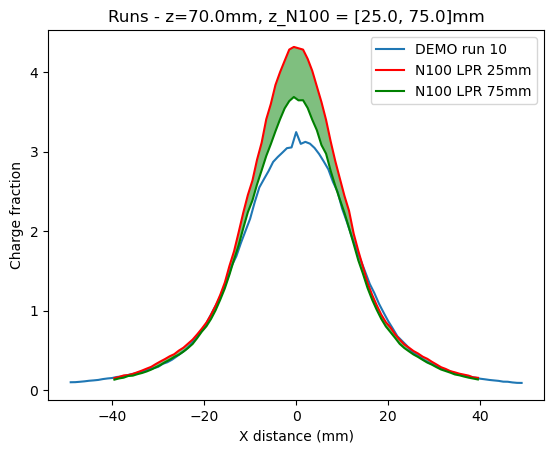

In [ ]:
psf_data_mine_cut = psf_data_mine[(psf_data_mine.z == z_pos)]
x_data8, y_data8 = sorted(set(psf_data_mine_cut.xr)), psf_data_mine_cut.groupby(['xr'])['factor'].sum().values

psf_data9_cut = psf_data9[(psf_data9.z == z_pos)]
x_data9, y_data9 = sorted(set(psf_data9_cut.xr)), psf_data9_cut.groupby(['xr'])['factor'].sum().values

psf_data10_cut = psf_data10[(psf_data10.z == z_pos)]
x_data10, y_data10 = sorted(set(psf_data10_cut.xr)), psf_data10_cut.groupby(['xr'])['factor'].sum().values

psf_dataN100_cut_l = psf_dataN100[(psf_dataN100.z == z_pos_N100_low)]
x_dataN100_l, y_dataN100_l = sorted(set(psf_dataN100_cut_l.xr)), psf_dataN100_cut_l.groupby(['xr'])['factor'].sum().values

psf_dataN100_cut_h = psf_dataN100[(psf_dataN100.z == z_pos_N100_high)]
x_dataN100_h, y_dataN100_h = sorted(set(psf_dataN100_cut_h.xr)), psf_dataN100_cut_h.groupby(['xr'])['factor'].sum().values




#plt.plot(x_data8, y_data8, label = 'data8')
#plt.plot(x_data9, y_data9, label = 'data9')
plt.plot(x_data10, y_data10, label = 'DEMO run 10')
plt.plot(x_dataN100_l, y_dataN100_l, label = 'N100 LPR 25mm', color = 'red')
plt.plot(x_dataN100_h, y_dataN100_h, label = 'N100 LPR 75mm', color = 'green')

# fill
plt.fill_between(x_dataN100_l, y_dataN100_l, y_dataN100_h, facecolor='green', alpha = 0.5)

plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'Runs - z={z_pos}mm, z_N100 = [{z_pos_N100_low}, {z_pos_N100_high}]mm')
plt.legend()

# FIRST MAIN PLOT

- LPR (no band)
- demo 10 (band)
- new (band)

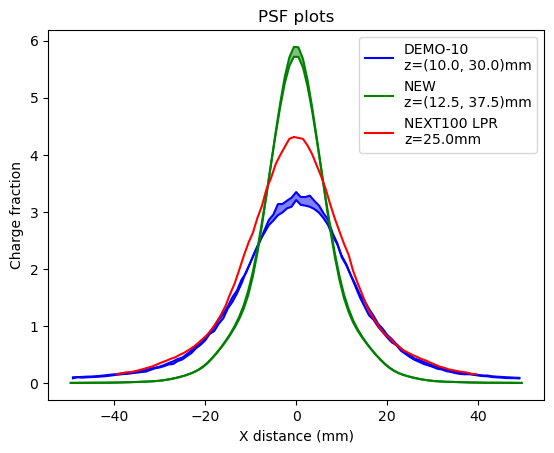

In [24]:
z_demo_band = (10., 30.)
z_N100 = (25.0)
z_new_band = (12.5, 37.5)

### demo

demo_l = psf_data10[(psf_data10.z == z_demo_band[0])]
x_data10_l, y_data10_l = sorted(set(demo_l.xr)), demo_l.groupby(['xr'])['factor'].sum().values

demo_h = psf_data10[(psf_data10.z == z_demo_band[1])]
x_data10_h, y_data10_h = sorted(set(demo_h.xr)), demo_h.groupby(['xr'])['factor'].sum().values

### NEW


new_l = psf_idk[(psf_idk.z == z_new_band[0])]
x_new_l, y_new_l = sorted(set(new_l.xr)), new_l.groupby(['xr'])['factor'].sum().values

new_h = psf_idk[(psf_idk.z == z_new_band[1])]
x_new_h, y_new_h = sorted(set(new_h.xr)), new_h.groupby(['xr'])['factor'].sum().values

### NEXT 100

N100 = psf_dataN100[(psf_dataN100.z == z_N100)]
x_N100, y_N100 = sorted(set(N100.xr)), N100.groupby(['xr'])['factor'].sum().values


### plotting

plt.plot(x_data10_l, y_data10_l, label = f'DEMO-10\nz={z_demo_band}mm', color = 'blue')
plt.plot(x_data10_h, y_data10_h, color = 'blue')
plt.fill_between(x_data10_l, y_data10_l, y_data10_h, facecolor='blue', alpha = 0.5)

plt.plot(x_new_l, y_new_l, label = f'NEW\nz={z_new_band}mm', color = 'green')
plt.plot(x_new_h, y_new_h, color = 'green')
plt.fill_between(x_new_l, y_new_l, y_new_h, facecolor='green', alpha = 0.5)

plt.plot(x_N100, y_N100, label = f'NEXT100 LPR\nz={z_N100}mm', color = 'red')



plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'PSF plots')
plt.legend()

### SECOND MAIN PLOT

- new (band)
- NEXT 100 LPR and HPR (no band)

can re-use the bits from above

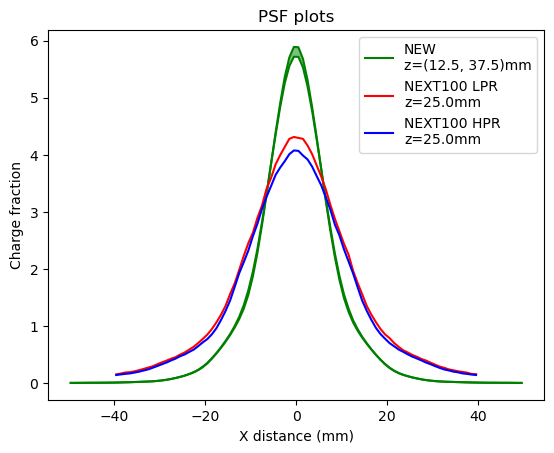

In [25]:
### N100 HPR
N100_hpr = psf_hpr[(psf_hpr.z == z_N100)]
x_N100_HPR, y_N100_HPR = sorted(set(N100_hpr.xr)), N100_hpr.groupby(['xr'])['factor'].sum().values


### plotting

plt.plot(x_new_l, y_new_l, label = f'NEW\nz={z_new_band}mm', color = 'green')
plt.plot(x_new_h, y_new_h, color = 'green')
plt.fill_between(x_new_l, y_new_l, y_new_h, facecolor='green', alpha = 0.5)

plt.plot(x_N100, y_N100, label = f'NEXT100 LPR\nz={z_N100}mm', color = 'red')

plt.plot(x_N100_HPR, y_N100_HPR, label = f'NEXT100 HPR\nz={z_N100}mm', color = 'blue')



plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'PSF plots')
plt.legend()

#### third plot, N100 PSF over z for all z

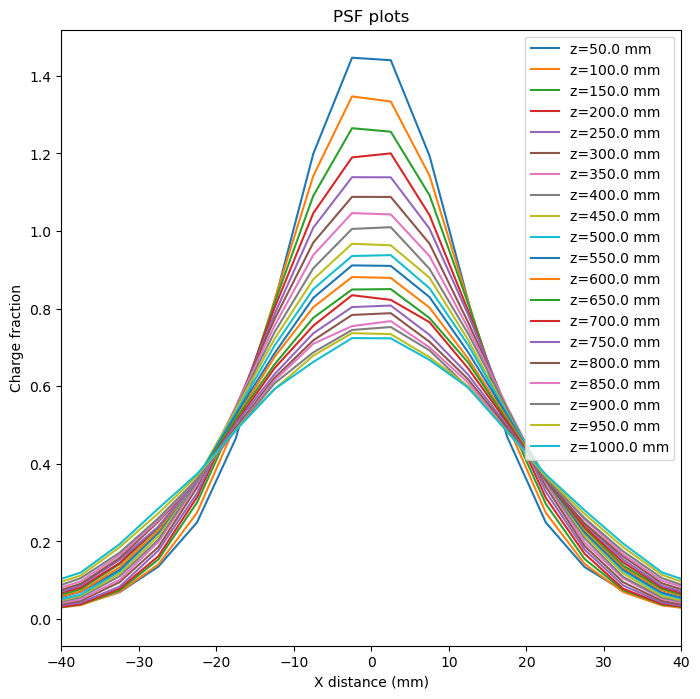

In [22]:
plt.figure(figsize=(8,8))

for z_val, df in psf_data_mine.groupby("z"):



    N100 = psf_data_mine[(psf_data_mine.z == z_val)]
    x_N100, y_N100 = sorted(set(N100.xr)), N100.groupby(['xr'])['factor'].sum().values

    ### plotting

    plt.plot(x_N100, y_N100, label = f'z={z_val} mm')



plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'PSF plots')
plt.xlim([-40, 40])
plt.legend()

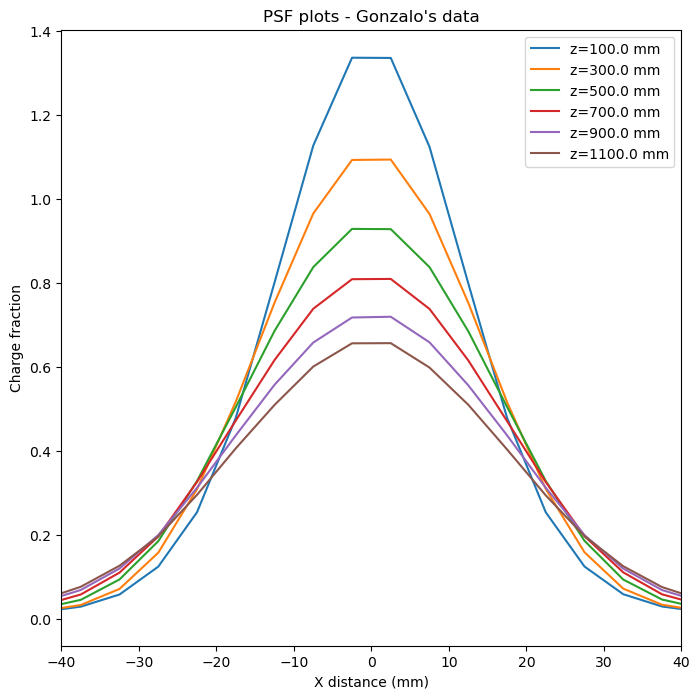

In [23]:
plt.figure(figsize=(8,8))

for z_val, df in psf_data_gonzalo.groupby("z"):



    N100 = psf_data_gonzalo[(psf_data_gonzalo.z == z_val)]
    x_N100, y_N100 = sorted(set(N100.xr)), N100.groupby(['xr'])['factor'].sum().values

    ### plotting

    plt.plot(x_N100, y_N100, label = f'z={z_val} mm')



plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'PSF plots - Gonzalo\'s data')
plt.xlim([-40, 40])
plt.legend()

In [23]:
display(psf_data_gonzalo)
visualiser = psf_data_mine[psf_data_mine['xr'] == -197.5]
visualiser = visualiser[visualiser['yr'] == -197.5]
visualiser = visualiser[visualiser['z'] == 100.0]
display(visualiser)
display(psf_data_mine)

,xr,yr,zr,x,y,z,factor,nevt
0,-197.5,-197.5,0.0,0.0,0.0,100.0,0.000025,7813
1,-197.5,-197.5,0.0,0.0,0.0,300.0,0.000047,9063
2,-197.5,-197.5,0.0,0.0,0.0,500.0,0.000066,7345
3,-197.5,-197.5,0.0,0.0,0.0,700.0,0.000104,5564
4,-197.5,-197.5,0.0,0.0,0.0,900.0,0.000059,3271
...,...,...,...,...,...,...,...,...
38395,197.5,197.5,0.0,0.0,0.0,300.0,0.000045,9514
38396,197.5,197.5,0.0,0.0,0.0,500.0,0.000073,7961
38397,197.5,197.5,0.0,0.0,0.0,700.0,0.000090,5778
38398,197.5,197.5,0.0,0.0,0.0,900.0,0.000093,3393


,xr,yr,zr,x,y,z,factor,nevt
964801,-197.5,-197.5,0,-250.0,-250.0,100.0,0.000057,152.0
964821,-197.5,-197.5,0,-250.0,250.0,100.0,0.000105,173.0
964841,-197.5,-197.5,0,250.0,-250.0,100.0,0.000000,163.0
964861,-197.5,-197.5,0,250.0,250.0,100.0,0.000063,149.0


,xr,yr,zr,x,y,z,factor,nevt
0,-497.5,-497.5,0,-250.0,-250.0,50.0,0.0,0.0
1,-497.5,-497.5,0,-250.0,-250.0,100.0,0.0,0.0
2,-497.5,-497.5,0,-250.0,-250.0,150.0,0.0,0.0
3,-497.5,-497.5,0,-250.0,-250.0,200.0,0.0,0.0
4,-497.5,-497.5,0,-250.0,-250.0,250.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3199995,497.5,497.5,0,250.0,250.0,800.0,0.0,0.0
3199996,497.5,497.5,0,250.0,250.0,850.0,0.0,0.0
3199997,497.5,497.5,0,250.0,250.0,900.0,0.0,0.0
3199998,497.5,497.5,0,250.0,250.0,950.0,0.0,0.0


In [34]:
columns = np.array(['xr', 'yr'])
for z_val, df in psf_dataN100.groupby("z"):
    psf = psf_dataN100.loc[(psf_dataN100.z == z_val) & 
                            (psf_dataN100.x == 0) &
                            (psf_dataN100.y == 0) , :]
    psf_deco = psf.factor.values.reshape(psf.loc[:, columns].nunique().values)
    plt.imshow(psf_deco, origin = 'lower', extent = [psf.xr.min(), psf.xr.max(), psf.yr.min(), psf.yr.max()])
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    #plt.imshow(im_deconv, norm=LogNorm(vmin = im_deconv.min(), vmax = im_deconv.max()))
    #plt.imshow(im_deconv)
    plt.title("PSF pre-iteration across Z slice: " + str(z_val))
    plt.colorbar()
    plt.savefig('/home/e78368jw/Downloads/PSF_images/PSF' + str(z_val) + '.png')
    plt.close()
    
    

In [31]:
np.unique(psf_dataN100.xr.values)

array([-39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5,
       -30.5, -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5,
       -21.5, -20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5,
       -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,
        -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,
         5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,
        14.5,  15.5,  16.5,  17.5,  18.5,  19.5,  20.5,  21.5,  22.5,
        23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,  30.5,  31.5,
        32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5])

In [36]:
psf_dataN100.head(10)

,xr,yr,zr,x,y,z,factor,nevt
0,-39.5,-39.5,0,0.0,0.0,25.0,0.000793,109.0
1,-39.5,-39.5,0,0.0,0.0,75.0,0.000713,137.0
2,-39.5,-39.5,0,0.0,0.0,125.0,0.000715,132.0
3,-39.5,-39.5,0,0.0,0.0,175.0,0.000758,121.0
4,-39.5,-39.5,0,0.0,0.0,225.0,0.000701,108.0
5,-39.5,-39.5,0,0.0,0.0,275.0,0.000589,81.0
6,-39.5,-39.5,0,0.0,0.0,325.0,0.000654,86.0
7,-39.5,-39.5,0,0.0,0.0,375.0,0.000739,83.0
8,-39.5,-39.5,0,0.0,0.0,425.0,0.000707,99.0
9,-39.5,-39.5,0,0.0,0.0,475.0,0.000676,93.0


In [37]:
psf_data8.head(10)

,nevt,xr,yr,zr,x,y,z,factor
0,176,-49.0,-49.0,0.0,0.0,0.0,10.0,0.000000
1,588,-49.0,-49.0,0.0,0.0,0.0,30.0,0.000040
2,820,-49.0,-49.0,0.0,0.0,0.0,50.0,0.000094
3,940,-49.0,-49.0,0.0,0.0,0.0,70.0,0.000378
4,964,-49.0,-49.0,0.0,0.0,0.0,90.0,0.000240
5,1040,-49.0,-49.0,0.0,0.0,0.0,110.0,0.000293
6,988,-49.0,-49.0,0.0,0.0,0.0,130.0,0.000170
7,1064,-49.0,-49.0,0.0,0.0,0.0,150.0,0.000256
8,1120,-49.0,-49.0,0.0,0.0,0.0,170.0,0.000084
9,1104,-49.0,-49.0,0.0,0.0,0.0,190.0,0.000211


In [18]:
psf_idk.head(10)

,xr,yr,zr,x,y,z,factor,nevt
0,-49.5,-49.5,0.0,0.0,0.0,12.5,0.000036,4839
1,-49.5,-49.5,0.0,0.0,0.0,37.5,0.000010,8436
2,-49.5,-49.5,0.0,0.0,0.0,62.5,0.000015,8133
3,-49.5,-49.5,0.0,0.0,0.0,87.5,0.000031,7816
4,-49.5,-49.5,0.0,0.0,0.0,112.5,0.000021,7726
5,-49.5,-49.5,0.0,0.0,0.0,137.5,0.000014,7815
6,-49.5,-49.5,0.0,0.0,0.0,162.5,0.000027,7868
7,-49.5,-49.5,0.0,0.0,0.0,187.5,0.000028,7833
8,-49.5,-49.5,0.0,0.0,0.0,212.5,0.000065,7656
9,-49.5,-49.5,0.0,0.0,0.0,237.5,0.000016,7716


In [16]:
psf_data7_cut = psf_data7[(psf_data7.z == z_pos)]
x_data7, y_data7 = sorted(set(psf_data7_cut.xr)), psf_data7_cut.groupby(['xr'])['factor'].sum().values


plt.plot(x, y, label = 'Run8 MC')
plt.plot(x_data, y_data, label = 'Run8 data')
plt.plot(x_data7, y_data7, label = 'Run7 data')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'z={z_pos}mm')
plt.legend()

NameError: name 'psf_data7' is not defined

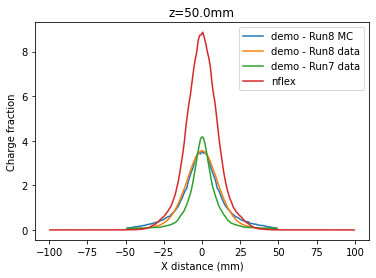

In [125]:
psf_nflex_cut = psf_nflex[(psf_nflex.z == z_pos)]
x_flex, y_flex = sorted(set(psf_nflex_cut.xr)), psf_nflex_cut.groupby(['xr'])['factor'].sum().values


plt.plot(x, y, label = 'demo - Run8 MC')
plt.plot(x_data, y_data, label = 'demo - Run8 data')
plt.plot(x_data7, y_data7, label = 'demo - Run7 data')
plt.plot(x_flex, y_flex, label = 'nflex')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'z={z_pos}mm')
plt.legend()

In [126]:
y_nw=y/max(y_data)
y_data_nw=y_data/max(y_data)
y_data7_nw=y_data7/max(y_data7)
y_flex_nw = y_flex/max(y_flex)

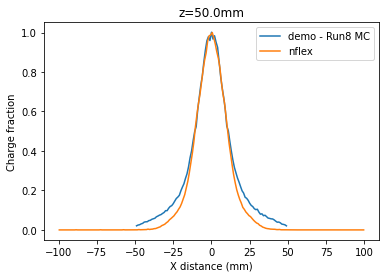

In [127]:
plt.plot(x, y_nw, label = 'demo - Run8 MC')
#plt.plot(x_data, y_data_nw, label = 'demo - Run8 data')
#plt.plot(x_data7, y_data7_nw, label = 'demo - Run7 data')
plt.plot(x_flex, y_flex_nw, label = 'nflex')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'z={z_pos}mm')
plt.legend()

In [98]:
psf_LT = pd.read_hdf("/data5/users/gdiaz/DEMOPP-Run8/LightTables/DEMOPP-Run8_PSF.h5", "PSF/LightTable")
psf_LT.head()

,dist_xy,z_m1,z_m2,z_m3,z_m4,z_m5
0,0,0.000028,0.000033,0.000038,0.000045,0.000054
1,1,0.000027,0.000032,0.000037,0.000044,0.000050
2,2,0.000027,0.000031,0.000035,0.000041,0.000047
3,3,0.000025,0.000029,0.000033,0.000038,0.000044
4,4,0.000024,0.000027,0.000030,0.000034,0.000039


In [116]:
charge_LT = psf_LT.drop(['dist_xy'], axis='columns').reset_index(drop=True).mean(axis=1).values
charge_LT= charge_LT/sum(charge_LT)
x_LT = psf_LT.dist_xy.values

In [117]:
x_LT

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [118]:
x_LT_nw = []
for i in x_LT: 
    x_LT_nw.append(i+0.5)

array([0.09054715, 0.08688947, 0.08259722, 0.07753012, 0.07093707,
       0.06379582, 0.05749449, 0.05075979, 0.04463916, 0.03915114,
       0.03710989, 0.03225313, 0.0278208 , 0.0241278 , 0.02161747,
       0.01858446, 0.01662031, 0.01507215, 0.01340642, 0.01114322,
       0.01056329, 0.00930542, 0.00835433, 0.00757385, 0.00683289,
       0.00616658, 0.00558701, 0.00511181, 0.00470618, 0.00427717,
       0.00408984, 0.00377909, 0.0035175 , 0.00327954, 0.00305824,
       0.00292917, 0.00274469, 0.00256766, 0.00244375, 0.00233898,
       0.00222404, 0.00212446, 0.00203173, 0.00196528, 0.00189524,
       0.00178286, 0.00173009, 0.00169122, 0.00164797, 0.00158307])

In [20]:
sum(charge_LT)

0.9999999999999998

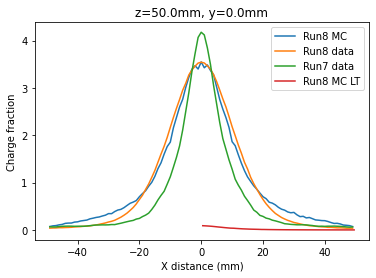

In [119]:
plt.plot(x, y, label = 'Run8 MC')
plt.plot(x_data, y_data, label = 'Run8 data')
plt.plot(x_data7, y_data7, label = 'Run7 data')
plt.plot(x_LT_nw, charge_LT, label = 'Run8 MC LT')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'z={z_pos}mm, y={y_pos}mm')
plt.legend()

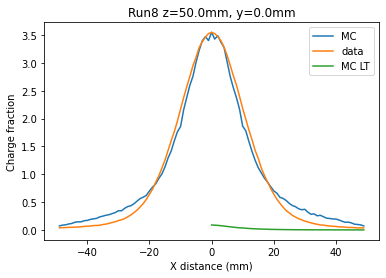

In [95]:
plt.plot(x, y, label = 'MC')
plt.plot(x_data, y_data, label = 'data')
plt.plot(x_LT, charge_LT, label = 'MC LT')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction')
plt.title(f'Run8 z={z_pos}mm, y={y_pos}mm')
plt.legend()

In [120]:
y=y/max(y)
y_data=y_data/max(y_data)
charge_LT=charge_LT/max(charge_LT)

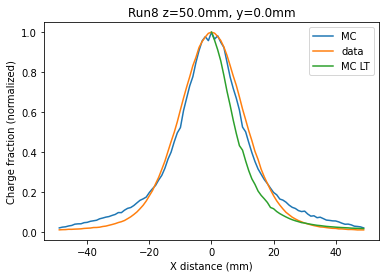

In [121]:
plt.plot(x, y, label = 'MC')
plt.plot(x_data, y_data, label = 'data')
plt.plot(x_LT, charge_LT, label = 'MC LT')
plt.xlabel('X distance (mm)')
plt.ylabel('Charge fraction (normalized)')
plt.title(f'Run8 z={z_pos}mm, y={y_pos}mm')
plt.legend()

### THE RR-INATOR

We need to extract `rr` from our results. Do this via `np.sqrt(xr**2 + yr**2)`.

- Add `rr` as new column
- Split df by `rr`
- Average `factor` for each `rr`
- Implement into new table

In [31]:
def rr_calc(df):
    df['rr'] = np.sqrt(np.square(df.xr) + np.square(df.yr))

In [ ]:
# test rr_calc
psf_R14675 = psf_data_mine.copy(deep=True)
display(psf_R14675)

rr_calc(psf_R14675)
display(psf_R14675)
# hehe it works in place!

,xr,yr,zr,x,y,z,factor,nevt
0,-497.5,-497.5,0,0.0,0.0,50.0,0.000000,24.0
1,-497.5,-497.5,0,0.0,0.0,100.0,0.000099,29.0
2,-497.5,-497.5,0,0.0,0.0,150.0,0.000000,27.0
3,-497.5,-497.5,0,0.0,0.0,200.0,0.000000,34.0
4,-497.5,-497.5,0,0.0,0.0,250.0,0.000000,25.0
...,...,...,...,...,...,...,...,...
799995,497.5,497.5,0,0.0,0.0,800.0,0.000000,33.0
799996,497.5,497.5,0,0.0,0.0,850.0,0.000000,34.0
799997,497.5,497.5,0,0.0,0.0,900.0,0.000000,40.0
799998,497.5,497.5,0,0.0,0.0,950.0,0.000000,47.0


,xr,yr,zr,x,y,z,factor,nevt,rr
0,-497.5,-497.5,0,0.0,0.0,50.0,0.000000,24.0,703.571247
1,-497.5,-497.5,0,0.0,0.0,100.0,0.000099,29.0,703.571247
2,-497.5,-497.5,0,0.0,0.0,150.0,0.000000,27.0,703.571247
3,-497.5,-497.5,0,0.0,0.0,200.0,0.000000,34.0,703.571247
4,-497.5,-497.5,0,0.0,0.0,250.0,0.000000,25.0,703.571247
...,...,...,...,...,...,...,...,...,...
799995,497.5,497.5,0,0.0,0.0,800.0,0.000000,33.0,703.571247
799996,497.5,497.5,0,0.0,0.0,850.0,0.000000,34.0,703.571247
799997,497.5,497.5,0,0.0,0.0,900.0,0.000000,40.0,703.571247
799998,497.5,497.5,0,0.0,0.0,950.0,0.000000,47.0,703.571247


In [45]:
# create new pandas dataframe
rr_df = pd.DataFrame(columns = ['rr', 'factor'])
display(rr_df)

for rr, df in psf_R14675.groupby('rr'):
    #display(df)
    #print(rr)

    factor_mean = df.factor.mean()
    #print(factor_mean)
    new_df = pd.DataFrame({'rr': [rr], 'factor': [factor_mean]})
    rr_df = pd.concat([rr_df, new_df], ignore_index = True)
    #break

display(rr_df)

,rr,factor


,rr,factor
0,3.535534,0.126218
1,7.905694,0.111676
2,10.606602,0.099205
3,12.747549,0.087754
4,14.577380,0.078652
...,...,...
3409,693.045814,0.000026
3410,696.500179,0.000029
3411,696.536072,0.000032
3412,700.044641,0.000037


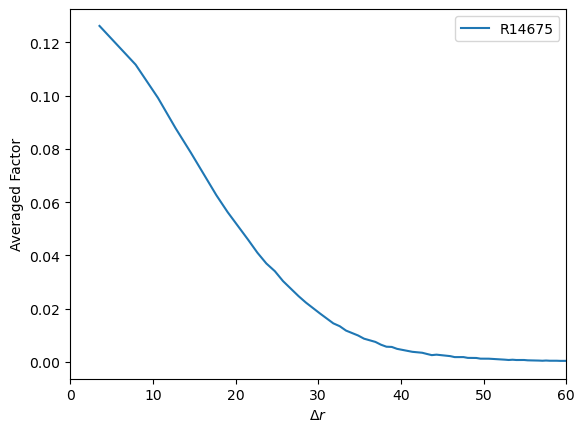

In [51]:
# lets try to display this bad boy
plt.plot(rr_df.rr, rr_df.factor, label = 'R14675')

plt.xlabel("$\Delta r$")
plt.ylabel("Averaged Factor")
plt.xlim([0, 60])


plt.legend()
plt.show()

### Lets make all that a oner-function

In [52]:
def rr_process(df_in):
    
    
    # new pandas dataframe
    rr_df = pd.DataFrame(columns = ['rr', 'factor'])

    def rr_calc(df):
        df['rr'] = np.sqrt(np.square(df.xr) + np.square(df.yr))


    psf = df_in.copy(deep=True)
    rr_calc(psf)




    for rr, df in psf.groupby('rr'):
        factor_mean = df.factor.mean()
        new_df = pd.DataFrame({'rr': [rr], 'factor': [factor_mean]})
        rr_df = pd.concat([rr_df, new_df], ignore_index = True)
    
    return rr_df

### gonzalos rewrite (not tested)

In [ ]:
def rr_process(df_in):    
    return (df_in.assign(rr = (df_in.xr**2 + df_in.yr**2)**0.5)
              .groupby("rr")
              .agg({'factor' : "mean"})
              .reset_index()
           )

In [64]:
gonzalo_rr = rr_process(psf_data_gonzalo)
new_rr     = rr_process(psf_NEW)
demo_rr    = rr_process(psf_data10)
mc_rr      = rr_process(psf_data_MC)
mc_4bar_rr = rr_process(psf_MC_4bar)

In [72]:
def plot_psf(df, label, norm = False):

    if norm:
        plt.plot((np.flip(-df.rr)).append(df.rr), (np.flip(norma(df.factor))).append(norma(df.factor)), label = label)
    else:
        plt.plot((np.flip(df.rr)).append(df.rr), (np.flip(df.factor)).append(df.factor), label = label)

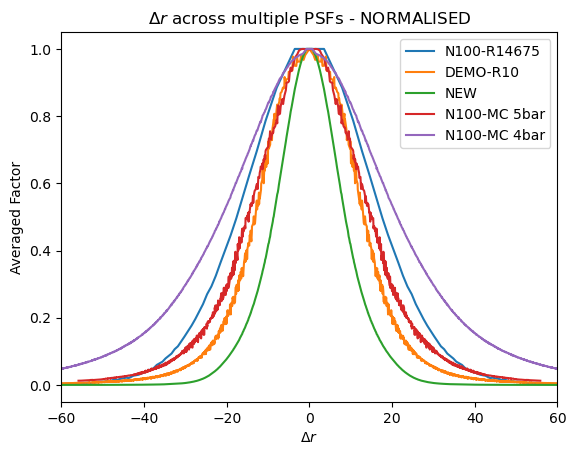

In [80]:
norm = True

plot_psf(rr_df, 'N100-R14675', norm)
plot_psf(demo_rr, 'DEMO-R10', norm)
plot_psf(new_rr, 'NEW', norm)
plot_psf(mc_rr, 'N100-MC 5bar', norm)
plot_psf(mc_4bar_rr, 'N100-MC 4bar', norm)


plt.xlabel("$\Delta r$")
plt.ylabel("Averaged Factor")

if norm:
    plt.title("$\Delta r$ across multiple PSFs - NORMALISED")
else:
    plt.title("$\Delta r$ across multiple PSFs")


plt.xlim([-60, 60])


plt.legend()
plt.show()

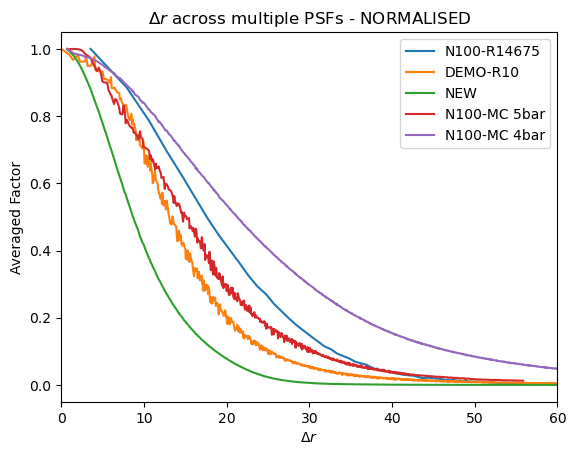

In [67]:
norm = True

if norm:
    # lets try to display this bad boy
    plt.plot(rr_df.rr, norma(rr_df.factor), label = 'N100-R14675')
    plt.plot(demo_rr.rr, norma(demo_rr.factor), label = 'DEMO-R10')
    plt.plot(new_rr.rr, norma(new_rr.factor), label = 'NEW')
    plt.plot(mc_rr.rr, norma(mc_rr.factor), label = 'N100-MC 5bar')
    plt.plot(mc_4bar_rr.rr, norma(mc_4bar_rr.factor), label = 'N100-MC 4bar')
    plt.title("$\Delta r$ across multiple PSFs - NORMALISED")
else:
    # lets try to display this bad boy
    plt.plot(rr_df.rr, rr_df.factor, label = 'N100-R14675')
    plt.plot(demo_rr.rr, demo_rr.factor, label = 'DEMO-R10')
    plt.plot(new_rr.rr, new_rr.factor, label = 'NEW')
    plt.plot(mc_4bar_rr.rr, mc_4bar_rr.factor, label = 'N100-MC 4bar')
    plt.plot(mc_rr.rr, mc_rr.factor, label = 'N100-MC 5bar')
    plt.title("$\Delta r$ across multiple PSFs")


plt.xlabel("$\Delta r$")
plt.ylabel("Averaged Factor")

plt.xlim([0, 60])


plt.legend()
plt.show()